In [288]:
%matplotlib inline
#%reset
import galsim
import matplotlib.pyplot as plt
import numpy as np
from chrom_objects import *
import short_cut_fns as sc

In [289]:
# Read SED from galsim data
# Flux density normalized to 1 at 550nm
datapath = '/Users/choyma/temp/Galsim/examples/data/'
SED_names = ['CWW_E_ext', 'CWW_Sbc_ext','CWW_Scd_ext', 'CWW_Im_ext']
SEDs = {}
for SED_name in SED_names:
    SED_filename = datapath+'{}.sed'.format(SED_name)
    SED = galsim.SED(SED_filename, wave_type='Ang')
    SEDs[SED_name] = SED.withFluxDensity(target_flux_density=1.0, wavelength=550) 
    
# euclid filetr used in Semboloni     
eu_filter=galsim.Bandpass('euclid_sem.txt').thin(rel_err=1e-4)      
red_SED=SEDs['CWW_E_ext']
blue_SED=SEDs['CWW_Im_ext']

In [290]:
# function to creat osf convolved with galaxy image
def im_chr_test(gal,psf,im_param):
    conv = galsim.Convolve([gal, psf])
    gal_im=conv.drawImage(im_param.filt,image=im_param.draw_image())
    return gal_im

#class that stores image parameters
class simple_image:
    def __init__(self,
                 I_size=[128,128], 
                 pixel_scale=None,
                 method='auto',
                 T_fn=None
                ):
        """Class to store parametrs used to draw images
        I_size     : Size of image; default=[128,128]
        pixel_scale: Scale to draw the image, in arcsec/pixel;default lets galsim pick scale depending on Nyquist scale
        method: """
        self.size=I_size
        self.scale=pixel_scale
        self.method=method
        self.filt=T_fn
    def draw_image(self):
        return galsim.ImageF(self.size[0],self.size[1],scale=self.scale)

In [291]:
I_size=2**8              # Image size
pixel_scale = 0.05       #pixel scale
w1=0.102                  
base_wavelength=800.
B1_re_b=0.17              # bulge r_e
B1_re_d=1.2               # disk r_e
B1_n_b=1.5                # bulge serseic  n 
B1_n_d=1.                 # disk sersic n
gal_flux=1e3              # galaxy flux
alpha=1                   # wavelength dependance of psf
sigma_800=w1              # psf sigma
redshift=0.3               # redshift of SED
t_b_flux=0.45               # bulge to total flux ratio

In [292]:
# Set bulge disk and composite SED
b_SED=red_SED.atRedshift(redshift)#.withFlux(bandpass=eu_filter,target_flux=1)
d_SED=blue_SED.atRedshift(redshift)#.withFlux(bandpass=eu_filter,target_flux=1)
c_SED=(t_b_flux*b_SED +((1-t_b_flux)*d_SED))

#set image parametrs
image_param=simple_image([I_size,I_size],pixel_scale,T_fn=eu_filter)

# PSF
psf=psf_chr(base_wavelength,alpha,sigma=sigma_800)
star = (galsim.Gaussian(fwhm=1.0e-8,flux=1))*c_SED
#draw psf image for shear estimation
psf_im=im_chr_test(star,psf,image_param)

In [293]:
'''w=galsim.Gaussian(sigma=2)
img = galsim.ImageF(I_size, I_size, scale=pixel_scale)
weight_fn=w.drawImage(image=img)
            #w1=weight_fn.flatten()
            #w1[w1<0]=0.
            #weight_fn=w1.reshape(I_size, I_size)
weight_fn.fill(1)'''

'w=galsim.Gaussian(sigma=2)\nimg = galsim.ImageF(I_size, I_size, scale=pixel_scale)\nweight_fn=w.drawImage(image=img)\n            #w1=weight_fn.flatten()\n            #w1[w1<0]=0.\n            #weight_fn=w1.reshape(I_size, I_size)\nweight_fn.fill(1)'

In [333]:
b_SED=red_SED.atRedshift(redshift)#.withFlux(bandpass=eu_filter,target_flux=1)
d_SED=blue_SED.atRedshift(redshift)#.withFlux(bandpass=eu_filter,target_flux=1)
c_SED=(t_b_flux*b_SED +((1-t_b_flux)*d_SED))

#set image parametrs
image_param=simple_image([I_size,I_size],pixel_scale,T_fn=eu_filter)

# PSF
psf=psf_chr(base_wavelength,alpha,sigma=sigma_800)
star = (galsim.Gaussian(fwhm=1.0e-8,flux=1))*c_SED
#draw psf image for shear estimation
psf_im=im_chr_test(star,psf,image_param)
#draw psf image to get effective psf
conv1=galsim.Convolve([psf,star])
#increase resolution when drawing
image_param2=simple_image([I_size*4,I_size*4],pixel_scale/4,method='no_pixel',T_fn=eu_filter)
psf_im_np=conv1.drawImage(eu_filter,method=image_param2.method,image=image_param2.draw_image())
psf2=galsim.InterpolatedImage(psf_im_np)  

#Galaxy  with CG  (_cg)
galaxy_cg=gal_chr(B1_re_b,B1_re_d,B1_n_b,B1_n_d,gal_flux,t_b_flux,b_SED=b_SED,d_SED=d_SED)

#Galxy without CG: effective _e   ### Deconvolved galaxy Semboloni
#deconvolve effective psf with the psf convolved cg galaxy          
inv_psf = galsim.Deconvolve(psf2)
conv=galsim.Convolve([galaxy_cg,psf])
deconv_gal = galsim.Convolve(inv_psf, conv)    
deconv_img=deconv_gal.drawImage(eu_filter,image=image_param2.draw_image(),method=image_param2.method)
galaxy_e=galsim.InterpolatedImage(deconv_img)*c_SED


galaxy_cg=galaxy_cg.shear(g1=0.01,g2=0.01)
galaxy_e=galaxy_e.shear(g1=0.01,g2=0.01)
gal1_im=im_chr_test(galaxy_cg,psf,image_param)
gal2_im=im_chr_test(galaxy_e,psf,image_param)
new_params = galsim.hsm.HSMParams(max_moment_nsig2=100,max_mom2_iter=1000000)
result1  = galsim.hsm.EstimateShear(gal1_im,psf_im,shear_est='LINEAR',
                                    precision=8e-07,strict=True,
                                    guess_x_centroid=127.,guess_y_centroid=127.,
                                    guess_sig_gal=50.0, guess_sig_PSF=5,
                                    hsmparams = new_params)
result2  = galsim.hsm.EstimateShear(gal2_im,psf_im,shear_est='LINEAR',strict=True)#,weight=weight)

In [334]:
a1=galsim.Shear(e1=result1.corrected_e1,e2=result1.corrected_e2)
a2=galsim.Shear(e1=result2.corrected_e1,e2=result2.corrected_e2)
a1.g1,a1.g2,a2.g1,a2.g2

(0.009836242930001939,
 0.00984643636706293,
 0.010078188114227192,
 0.010088658308656481)

In [335]:
a1.g1/a2.g1-1

-0.024006813673551508

In [320]:
result1.moments_sigma*pixel_scale,result2.moments_sigma*pixel_scale

(0.17694904804229739, 0.1769491195678711)

In [321]:
result1.moments_amp,result2.moments_amp

(54551.8125, 54551.8359375)

In [322]:
result1.moments_centroid

PositionD(x=0.0, y=0.0)

In [300]:
result1.resolution_factor,result2.resolution_factor

(0.7318076491355896, 0.7318098545074463)

In [336]:
result1.moments_n_iter,result1.moments_n_iter

(49, 49)

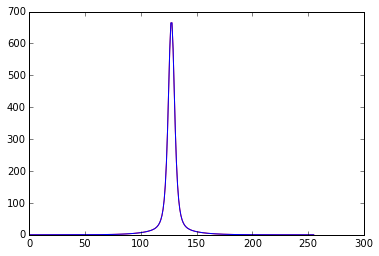

In [301]:
plt.plot(gal1_im.array[:][128],'r')
plt.plot(gal2_im.array[:][128],'b')
#plt.xlim([100,150])

('flux', 101253.73, 101253.73)


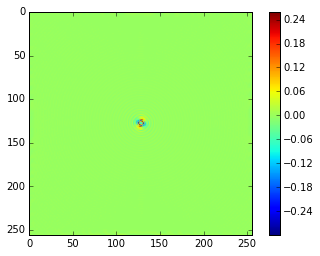

In [302]:
plt.imshow(np.array(gal1_im.array)-np.array(gal2_im.array))
plt.colorbar()
print('flux',gal1_im.array.sum(),gal2_im.array.sum())

In [303]:
a=gal1_im.FindAdaptiveMom()
b=gal2_im.FindAdaptiveMom()

In [304]:
a.moments_sigma*pixel_scale,b.moments_sigma*pixel_scale

(0.1786238193511963, 0.17862389087677003)

In [305]:
a.observed_shape,b.observed_shape

(Shear(g1=0.00601203907333, g2=0.00601825039318),
 Shear(g1=0.00616034719272, g2=0.00616674598529))

In [306]:
a.observed_shape.g1/b.observed_shape.g1-1

-0.02407463650153563

In [307]:
a.moments_amp,b.moments_amp

(46483.91796875, 46483.95703125)